This notebook is based on the ```single_static_target``` example. It is extended to include multiple receiving antennas, which allows to estimate target angles (direction of arrival, DOA also known as angle of arrival, AOA).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c0
import skradar

# Scene Setup
See the ```single_static_target``` example for a detailed description of the configuration of radar, target, and scene.

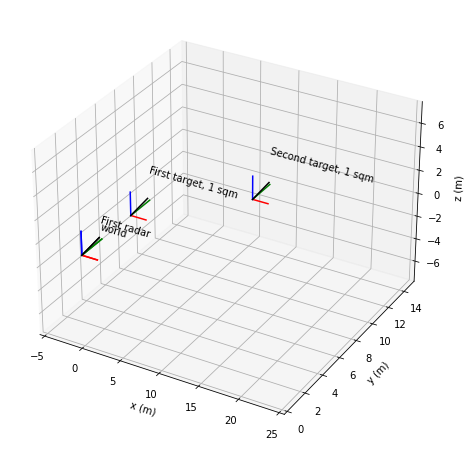

In [18]:
B = 1e9
fc = 76.5e9
N_f = 512  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate
Ts_s = (N_f-1)/fs_f  # slow-time sampling interval
N_s = 1  # number of slow-time samples

lambd = c0/fc

tx_pos = np.array([[0], [0], [0]])
rx_pos = np.zeros((3, 4))
rx_pos[0, :] = np.arange(4)*lambd/2  # half-wavelength receive array along x

radar_pos = np.array([[0], [0], [0]])
radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1/fs_f, T_s=Ts_s,
                          N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos,
                          pos=radar_pos, name='First radar')

target_lst = list()
target_lst.append(skradar.Target(rcs=1, pos=np.array([[0], [5], [0]]), name='First target, 1 sqm'))
target_lst.append(skradar.Target(rcs=1, pos=np.array([[10], [10], [0]]), name='Second target, 1 sqm'))

scene = skradar.Scene([radar], target_lst)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-5, 25))
ax.set_ylim((0, 15))
ax.set_zlim((-7.5, 7.5))
scene.visualize('world', ax, coord_len=2)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)');

# Radar Signal Simulation and Range Processing
Simulate chirps and perform range-compression

In [22]:
radar.sim_chirps()
radar.range_compression(zp_fact=32)  # the result is available as radar.rp (rp stands for range-profile)

We now should see several range profiles with maxima around the two target distances. The peaks stemming from the first target should overlap almost perfectly, whereas the distances of the second target should be slightly different across the RX channels.

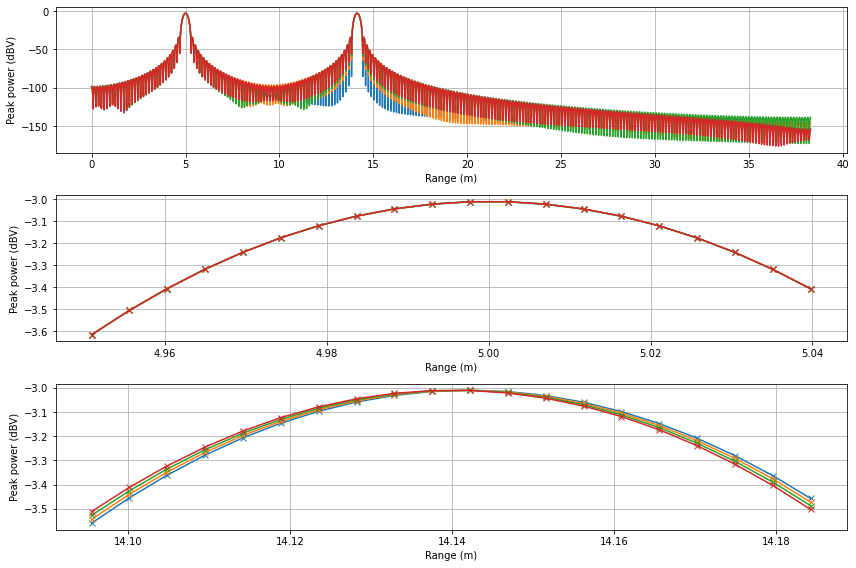

In [32]:
target_dists = radar.ranges/2  # halve values to account for round-trip ranges
target_dists_plot = target_dists[:len(radar.ranges)//2]
# sqrt(2) to convert to RMS power from sinusoidal peak value
rp_plot = 1/(np.sqrt(2))*radar.rp[0, :, 0, :len(radar.ranges)//2]

plot_idx1 = np.argmin(np.abs(target_dists_plot-np.sqrt(5**2)))
plot_idx2 = np.argmin(np.abs(target_dists_plot-np.sqrt(10**2+10**2)))

plt.figure(2, figsize=(12, 8))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(target_dists_plot, 20*np.log10(np.abs(rp_plot.T)))
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('Peak power (dBV)')
plt.subplot(3, 1, 2)
plt.plot(target_dists_plot[plot_idx1-10:plot_idx1+10], 20 *
         np.log10(np.abs(rp_plot[:, plot_idx1-10:plot_idx1+10].T)), '-x')
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('Peak power (dBV)')
plt.subplot(3, 1, 3)
plt.plot(target_dists_plot[plot_idx2-10:plot_idx2+10], 20 *
         np.log10(np.abs(rp_plot[:, plot_idx2-10:plot_idx2+10].T)), '-x')
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('Peak power (dBV)')
plt.tight_layout()